# Modèle LASSO linéaire (fonction de coût $\ell_2$ et pénalité $\ell_1$)

In [ ]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

## Théorie

### Fondamentaux

La régression LASSO (Least Absolute Shrinkage and Selection Operator) est une technique de régularisation qui ajoute une pénalité L1 aux coefficients du modèle. 

Cette méthode présente deux avantages majeurs : elle permet une sélection automatique des variables en réduisant certains coefficients exactement à zéro, tout en limitant le sur-apprentissage grâce à la pénalisation des coefficients élevés.

Contrairement à la régularisation Ridge (L2) qui ne fait que réduire l'amplitude des coefficients, le LASSO peut éliminer des variables du modèle. C'est pourqoui on l'utilise pour nos modèle de régression linéaire parcimonieux.

Pour ce faire, on résout ce problème de minimisation :

$$ \boxed{\min_{\beta\in\mathbb{R}^p}\|y-X\beta\|_2^2+\lambda\|\beta\|_1}$$

avec une pénalité $\|\beta\|_1=\sum_{j=1}^p|\beta_j|$

### Choix du $\lambda$

#### Trouver $\lambda_0(\cdot)$

##### **LASSO :** ($\xi = \beta$)

On cherche pour quel $\lambda$ la solution du problème  
$$
\hat{\beta}_\lambda(y) = \arg\min_{\beta}\|y - X\beta\|_2^2 + \lambda\|\beta\|_1
$$
devient nulle.

Calcul du gradient au point $\beta = 0$ :

(ici la sous-différentielle car pas possible d'avoir le gradient partout)
$$
-2 X^\top y + \lambda \cdot \partial \|\beta\|_1
$$

Pour que $\hat{\beta}_\lambda(y) = 0$ soit minimum, il faut que :

(Quand la fonction n’est pas différentiable partout, on remplace la condition
“le gradient est nul” par la condition “0 est dans la sous-différentielle”)
$$
0 \in -2 X^\top y + \lambda \cdot \partial \|\beta\|_1 \quad \text{en} \quad \beta=0
$$
Soit
$$
2 X^\top y \in \lambda \cdot \partial \|\beta\|_1
$$
Or,
$$\|\beta\|_1=\sum_{j=1}^p|\beta_j|$$
et
$$\partial|x|= \text{Cste} \in [-1,1] \quad \text{avec la sous-différentielle au point} \quad \beta=0$$
Donc :
$$\partial\|\beta\|_1=\{v\in\mathbb{R}^p:v_j\in[-1,1]\text{ pour tout }j\} \quad \text{au point} \quad \beta = 0$$

Ainsi :
$$
2 X^\top y \in \lambda \cdot \partial \|\beta\|_1 \quad\Longleftrightarrow\quad  \text{chaque composante de } 2 X^\top y \text{ est dans }[-\lambda,\lambda]
$$
$$
\quad\Longleftrightarrow\quad \left\|X^\top y\right\|_\infty \leq \frac{\lambda}{2}
$$

Donc :
$$
\lambda_0(y) = 2 \cdot \left\| X^\top y \right\|_\infty
$$



#### Algorithme

$$
\boxed{
\begin{array}{ll}
\textbf{QUT Simulation Algorithm (LASSO, oracle)} \\
\\
\textbf{Step 0.} & \text{Fixer } M \in \mathbb{N} \text{ (nombre de simulations), } \alpha \in (0, 1), \text{ et connaître } \sigma^2. \\
& \text{Initialiser un vecteur } \Lambda \leftarrow \emptyset. \\
\\
\textbf{Step m.} & \text{Pour } m = 1 \text{ à } M : \\
& \quad \text{Simuler } Y_{\text{Sim}}^{(m)} \sim \mathcal{N}(0, \sigma I_n). \\
& \quad \text{Calculer } \lambda_0^{(m)} \leftarrow 2 \cdot \left\| X^\top Y_{\text{Sim}}^{(m)} \right\|_\infty. \\
& \quad \text{Ajouter } \lambda_0^{(m)} \text{ à } \Lambda. \\
\\
\textbf{Final Step.} & \text{Définir le seuil } \lambda^{\text{QUT}} \leftarrow \text{quantile}_{1 - \alpha}(\Lambda).
\end{array}
}
$$

#### Test

In [12]:
import numpy as np
from linear_tools import ista, qut_lasso_oracle, generate_data

M, N_matrices = 1000, 20
n, p = 100, 200
alpha, sigma = 0.05, 0.1
alpha_hats = []

def grad_f(beta, y, X):
    return -2 * X.T @ (y - X @ beta)

def prox_g(beta, lmbda, L):
    return np.sign(beta) * np.maximum(np.abs(beta) - lmbda / L, 0.0)

for i in range(N_matrices):

    _, X, _ = generate_data(n, p, s=0, sigma=0, seed=i)

    lambda_qut = qut_lasso_oracle(X, sigma, M, alpha, seed=i)

    L = 2 * np.linalg.norm(X, ord=2) ** 2

    rng = np.random.default_rng(42 + i)
    non_zero_count = 0
    for _ in range(M):
        y = rng.normal(0, sigma, n)
        beta_hat = ista(
            grad_f=grad_f,
            prox_g=prox_g,
            x0=np.zeros(p),
            L=L,
            grad_f_args=(y, X),
            prox_g_args=(lambda_qut, L),
            max_iter=1000,
            tol=1e-6
        )
        if np.any(beta_hat != 0):
            non_zero_count += 1

    alpha_hat = non_zero_count / M
    alpha_hats.append(alpha_hat)

print(f"\t→ Moyenne de alpha_hat : {np.mean(alpha_hats):.4f} ± {np.std(alpha_hats):.4f} (attendu ≈ {alpha})")

	→ Moyenne de alpha_hat : 0.0515 ± 0.0114 (attendu ≈ 0.05)


### Optimisation

Pour résoudre ce problème de minisation on peut utiliser dans notre cas 2 méthodes ISTA et CD (Coordinate descent) qui sont expliqué en profondeur dans les notebooks présent dans le dossier OUTILS.

#### ISTA

On se ramène à un problème à résoudre de cette forme :  
$$\min_{\beta\in\mathbb{R}^p} F(\beta) := f(\beta) + g(\beta)$$

avec

- $f(\beta) = \|y - X\beta\|_2^2$ :  
    Il s'agit du terme d'erreur quadratique (moindre carrés) (MSE).  
    $f$ est une fonction convexe, différentiable, à gradient lipschitzien.

- $g(\beta) = \lambda \|\beta\|_1$ :  
    Il s'agit du terme de pénalisation $\ell_1$. 
    $g$ est convexe, non différentiable, mais proximable.

On peut ainsi très bien utiliser ISTA pour résoudre ce problème.

Le gradient de la fonction $f$ se calcule comme suit :

$$
\nabla f(\beta) = -2 X^\top (y - X\beta)
$$

##### Constante L


Par définition,  $L$ est tel que :
$$\|\nabla f(a) - \nabla f(b)\|_2 \leq L \|a - b\|_2, \quad \forall a, b \in \mathbb{R}^p$$

Or, 
$$\nabla f(\beta) = -2 X^\top (y - X\beta)$$

Donc 
$$\|\nabla f(a) - \nabla f(b)\|_2 = \left\| 2 X^\top X (a - b) \right\|_2 \leq \left\| 2 X^\top X \right\|_2 \|a - b\|_2$$

Ainsi, 
$$L = \left\| 2 X^\top X \right\|_2 = 2 \|X\|_2^2$$

##### Proximal de g

Dans notre cas, le proximal du terme de pénalisation $\ell_1$ avec un pas $\gamma = 1/L$ s'écrit :

$$
\text{prox}_{\frac{\lambda}{L} \|\cdot\|_1}(z) = \arg\min_{x \in \mathbb{R}^p} \left\{ \frac{L}{2} \|x - z\|_2^2 + \lambda \|x\|_1 \right\}
$$

Ce proximal correspond toujours à l'opérateur de seuillage doux:

$$
\text{prox}_{\frac{\lambda}{L} \|\cdot\|_1}(z) = \operatorname{sign}(z) \odot \max\left(|z| - \frac{\lambda}{L},\, 0\right)
$$

où $\odot$ désigne le produit terme à terme (Hadamard) entre les vecteurs.

#### Coordinate descent

Comme pour ISTA, on se ramène à un problème de la forme suivante :

$$\min_\beta h(\beta) := f(\beta) + \lambda \Omega(\beta),$$

où dans notre cas :

- $f : \mathbb{R}^p \to \mathbb{R} = \|y - X\beta\|_2^2$
- $\Omega : \mathbb{R}^p \to \mathbb{R}$ est la fonction de pénalisation, non lisse mais séparable :
    - $\Omega(\beta) = \sum_{j=1}^p \Omega_j(\beta_j)$ avec $\Omega_j : \mathbb{R} \to \mathbb{R} = |\beta_j|$.
- $\lambda > 0$ est le paramètre de régularisation.

##### Constante L

C'est la même que pour ista

En coordinate descent pour le LASSO, chaque coordonnée $j$ possède sa propre constante de Lipschitz $L_j$ pour le gradient par rapport à $\beta_j$. 

Formellement, pour $f(\beta) = \|y - X\beta\|_2^2$, on a :

$$
L_j = 2 \|X_{:,j}\|_2^2
$$

où $X_{:,j}$ désigne la $j$-ème colonne de $X$.

##### Proximal de $\Omega$

Le proximal de $\Omega$ pour la pénalité $\ell_1$ (coordinatewise) s'écrit :

$$
\operatorname{prox}_{\tau |\cdot|}(v_j) = \operatorname{sign}(v_j) \cdot \max\left(|v_j| - \tau,\, 0\right)
$$

où $\tau = \lambda / L_j$ et $v_j$ est la $j$-ème coordonnée.  
Ceci correspond à l'opérateur de seuillage doux (soft-thresholding).


## Simulations

In [2]:
n = 70
p = 250
list_s = range(0, 31)

sigma = 0.1

simu_iter=20
qut_iter=1000
max_iter=10000
tol=1e-6

seed=43

### LASSO avec ISTA en ORACLE

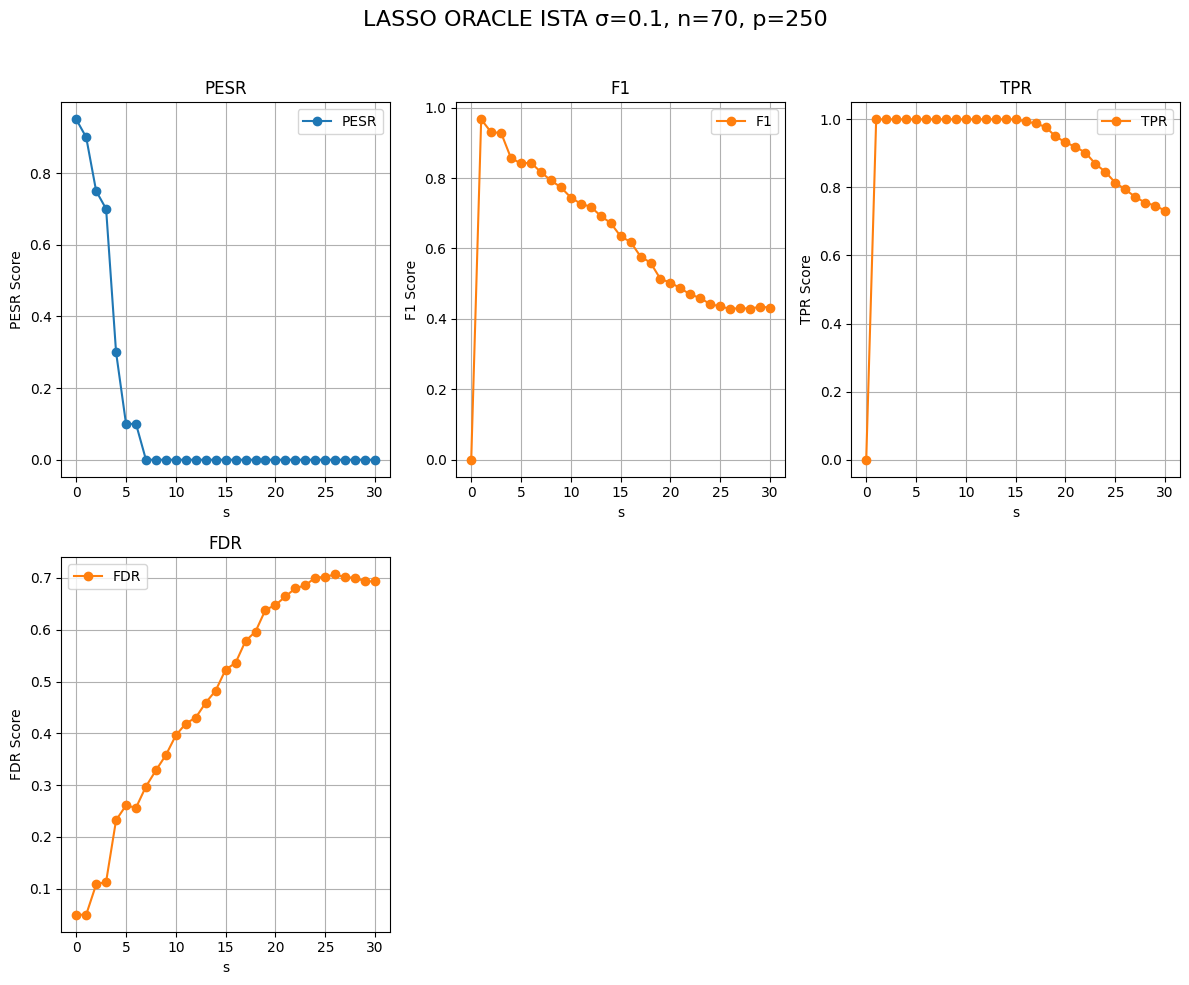

In [4]:
from simulations import SimulationLassoOracleIsta

Sim1 = SimulationLassoOracleIsta(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim1.run()

Sim1.plot()

### LASSO avec ISTA backtracking en ORACLE

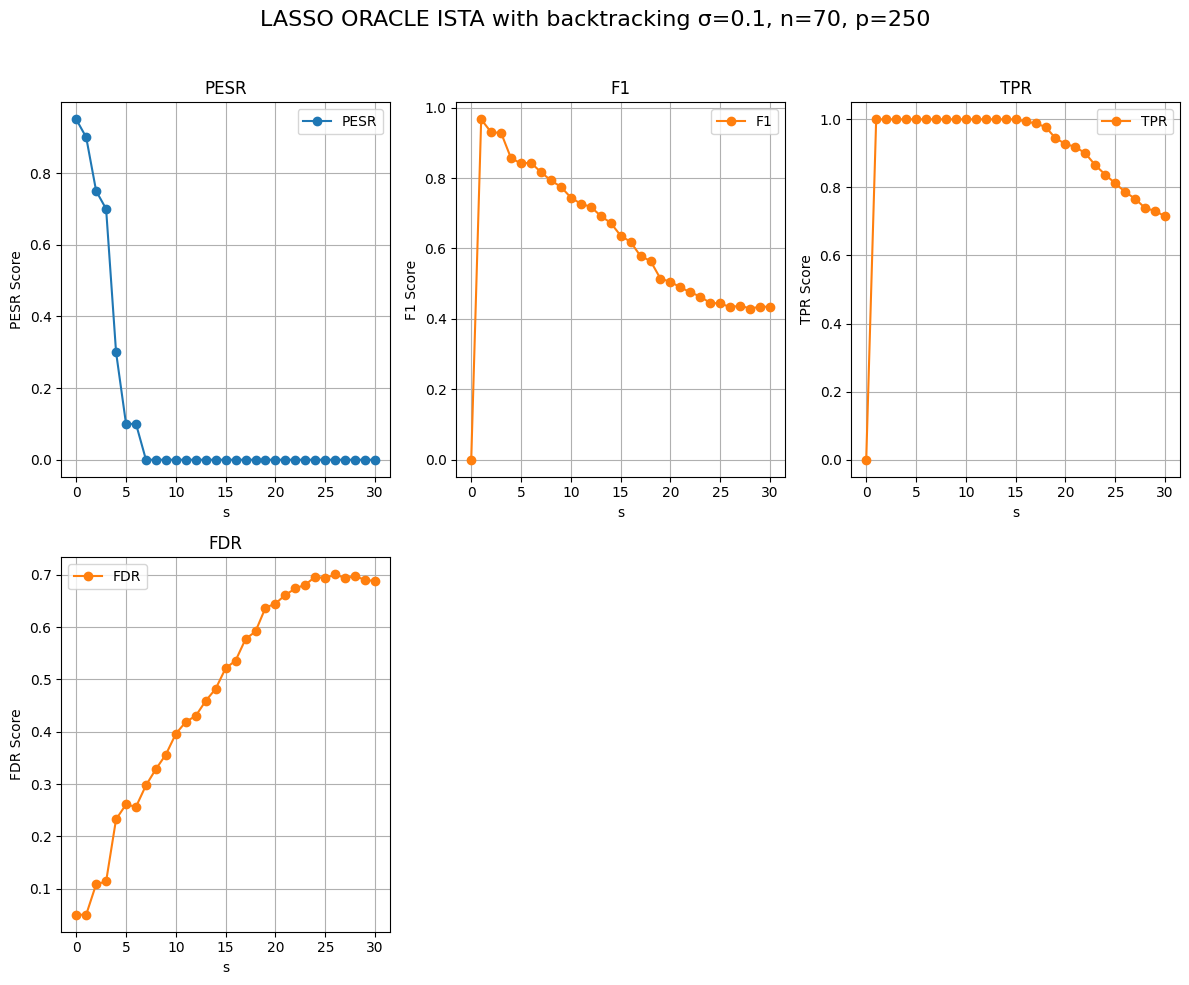

In [5]:
from simulations import SimulationLassoOracleIstaBacktracking

Sim2 = SimulationLassoOracleIstaBacktracking(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim2.run()

Sim2.plot()

### LASSO avec Cordinate Descent en ORACLE

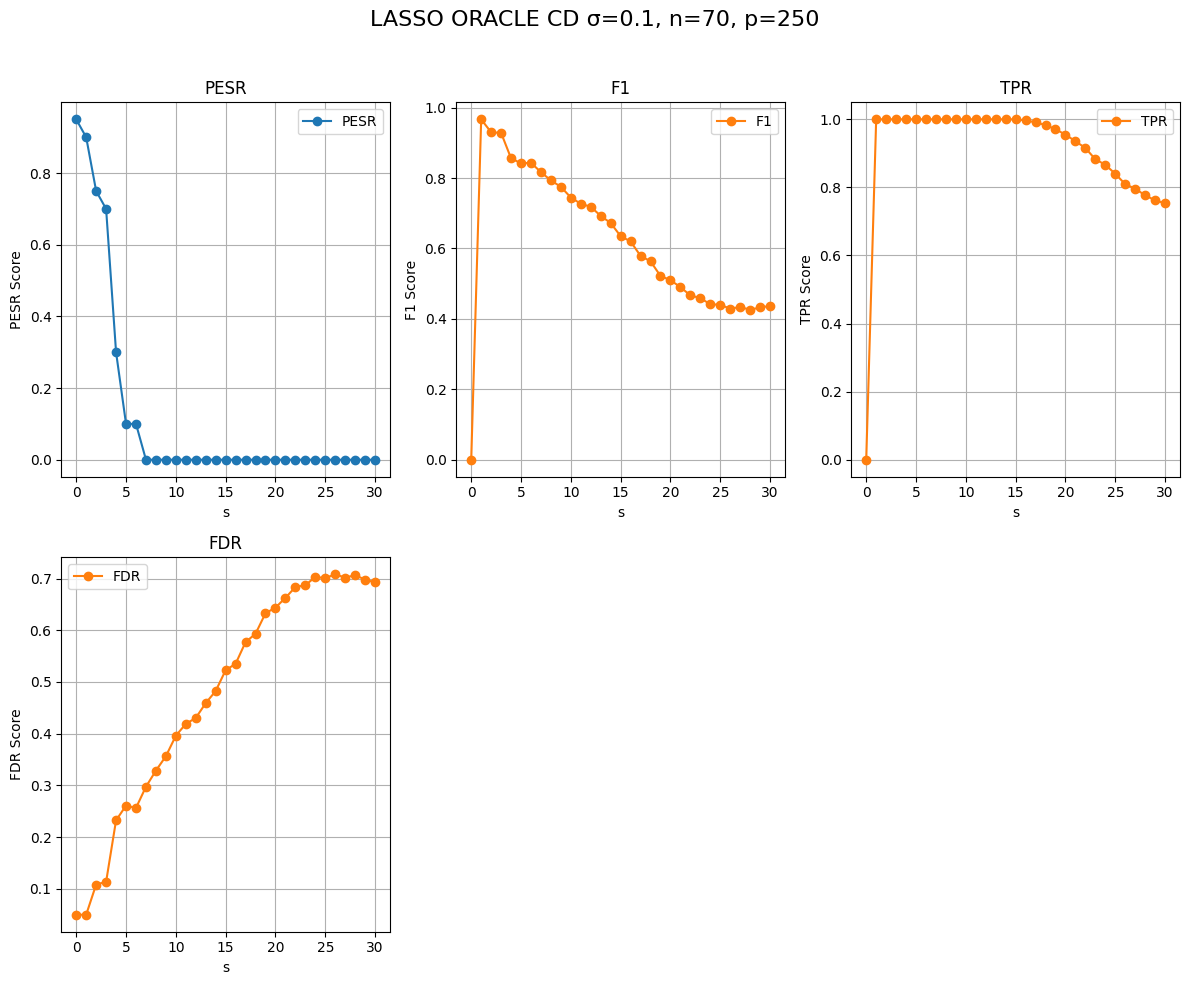

In [3]:
from simulations import SimulationLassoOracleCd

Sim3 = SimulationLassoOracleCd(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter*10,
    tol = tol*1e-1,
    seed = seed,
    verbose=False
)

Sim3.run()

Sim3.plot()

### Comparaison des simulations

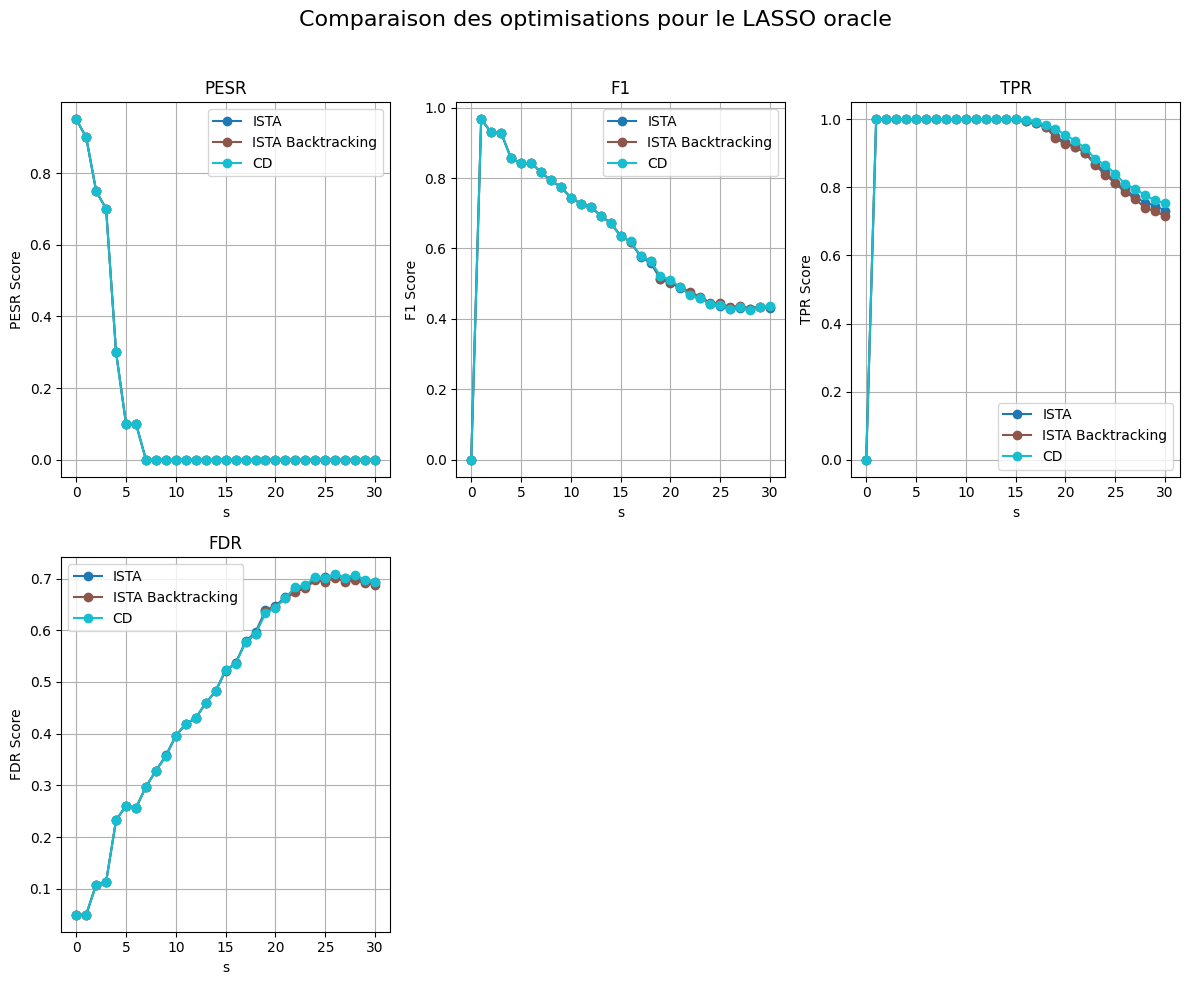

In [6]:
from linear_tools import plot_simulations

simulations = {
    'ISTA': Sim1.score,
    'ISTA Backtracking': Sim2.score,
    'CD': Sim3.score
}

plot_simulations(simulations, Sim1.list_s, "Comparaison des optimisations pour le LASSO oracle")